# Poisson Ring Attractor Demo
This notebook demonstrates training xFADS models with Poisson observations from a 2D ring attractor system.

TODO fix train and valid
TODO fix training
TODO fix generation of observations (parallelize)

In [178]:
# Setup and imports
import sys
sys.path.append('../..') # add path for xfads root

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from hydra import compose, initialize
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Timer
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import PoissonLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL, LowRankNonlinearStateSpaceModel

from snr import generate_poisson_observations
from in_progress.utils.ring_attractor_data import data_gen

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
# Initialize configuration
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

initialize(version_base=None, config_path='./ra_xfads_training', job_name="poisson_lds")
cfg = compose(config_name="config")

pl.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)
torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg['device'] = device
print(f"Using device: {device}")
cfg['n_epochs'] = 50  # reduced for demo

Seed set to 1234


Using device: cpu


## Generate Ring Attractor Data with Poisson Observations

In [180]:
# Generate latent trajectories and readout matrix
n_trials = 200  # ✅ Increased from 20 for better training
n_time_bins = 100  # ✅ Reduced from 750 for faster training  
n_neurons = 50   # ✅ Reduced from 100 for faster training
perturbation_magnitude = 1e-1

kw = data_gen(n_neurons, n_time_bins, n_trials, perturbation_magnitude, 
              rnn_kwargs={'t_conj': 10}, cfg=cfg)

z_true = kw['z_train']  # True latent trajectories
y_gaussian = kw['y_train']  # Gaussian observations
C_matrix = kw['C'].weight.detach().numpy().T  # Readout matrix (reference only)

print(f"Generated data:")
print(f"  Latent shape: {z_true.shape}")
print(f"  Gaussian obs shape: {y_gaussian.shape}")
print(f"  Readout matrix shape: {C_matrix.shape}")
print(f"✅ Increased data size for better training")

Generated data:
  Latent shape: torch.Size([133, 100, 2])
  Gaussian obs shape: torch.Size([133, 100, 50])
  Readout matrix shape: (2, 50)
✅ Increased data size for better training


/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


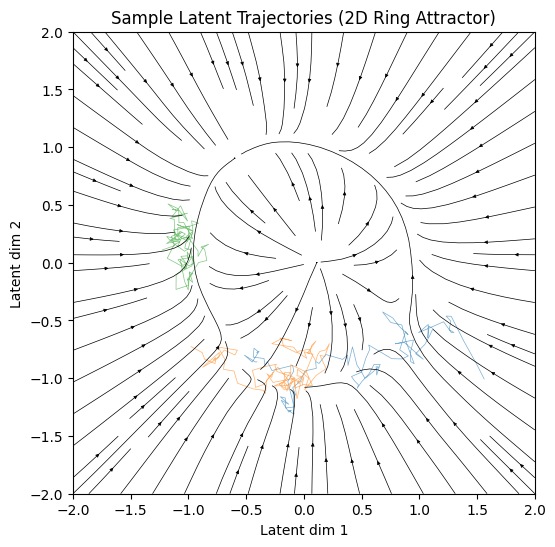

In [181]:
from in_progress.test_dynamics import PerturbedRingAttractorRNN as PerturbedRingAttractorDynamics

mean_fn = PerturbedRingAttractorDynamics(bin_sz=1e-1,lengthscale=0.2,perturbation_magnitude=perturbation_magnitude).to(cfg.device)

fig, axs = plt.subplots(figsize=(6, 6))
for i in range(3):
    axs.plot(z_true[i, :, 0].cpu(), z_true[i, :, 1].cpu(), alpha=0.6, linewidth=0.5)

plot_utils.plot_two_d_vector_field(mean_fn.to('cpu'), axs, min_xy=-2, max_xy=2)
axs.set_title("Sample Latent Trajectories (2D Ring Attractor)")
axs.set_xlabel("Latent dim 1")
axs.set_ylabel("Latent dim 2")
axs.set_xlim(-2, 2)
axs.set_ylim(-2, 2)
axs.set_box_aspect(1.0)
plt.show()
fig.savefig(
    f'latent_traj_perturb_{perturbation_magnitude}.png',
    dpi=300, bbox_inches='tight'
)

Spiking range 15-20, 10-12 average firing rate

In [182]:
# Convert Gaussian observations to Poisson spike counts
rate = torch.nn.functional.softplus(5 * y_gaussian).squeeze()  # ✅ Reduced multiplier for more reasonable rates

print(f"Rate shape: {rate.squeeze().shape}")

y_poisson = torch.distributions.poisson.Poisson(rate).sample()

print(f"Poisson observations:")
print(f"  Shape: {y_poisson.shape}")
print(f"  Range: {y_poisson.min()} to {y_poisson.max()}")
print(f"  Mean spike count: {y_poisson.float().mean():.3f}")
print(f"  Rate statistics: min={rate.min():.3f}, max={rate.max():.3f}, mean={rate.mean():.3f}")
print(f"✅ More reasonable rate scaling for Poisson observations")

Rate shape: torch.Size([133, 100, 50])
Poisson observations:
  Shape: torch.Size([133, 100, 50])
  Range: 0.0 to 58.0
  Mean spike count: 1.844
  Rate statistics: min=0.000, max=57.116, mean=1.843
✅ More reasonable rate scaling for Poisson observations


In [183]:
z_true[0,:,:].shape

torch.Size([100, 2])

In [184]:
from snr import compute_SNR

# Generate Poisson observations for each trial in z_true and collate into one tensor
all_observations = []
all_firing_rates = []
for i in range(z_true.shape[0]):
    obs, C, b, firing_rate_per_bin, SNR = generate_poisson_observations(
        z_true[i, :, :].detach().numpy(),
        # C=C_matrix,
        dNeurons=100,
        targetRatePerBin=1.0,
        pCoherence=0.5,
        pSparsity=0.1,
        targetSNR=1.0,
        SNR_method=compute_SNR,
    )
    all_observations.append(obs)
    all_firing_rates.append(firing_rate_per_bin)

# TODO
# for the snr you can concatenate data array into a trials x time, neuron
# Iirc the snr computation only depends pointwise on time
# flatten on 

# TODO With current setup, use correct C_matrix and keep track of them for each traj
# Effect of simply starting with random C matrix in the Gaussian case? 
# Hyunju does random C -> scale for SNR, treats each trajectory as independent and gets a specific C for each one 

# Stack observations into a single tensor/array of shape (n_trials, n_time_bins, n_neurons)
observations = np.stack(all_observations, axis=0)
firing_rate_per_bin = np.stack(all_firing_rates, axis=0)

print("Generated observations shape:", observations.shape)
print("C shape:", C.shape)
print("b shape:", b.shape)
print("Firing rate per bin shape:", firing_rate_per_bin.shape)
print("SNR:", SNR)

KeyboardInterrupt: 

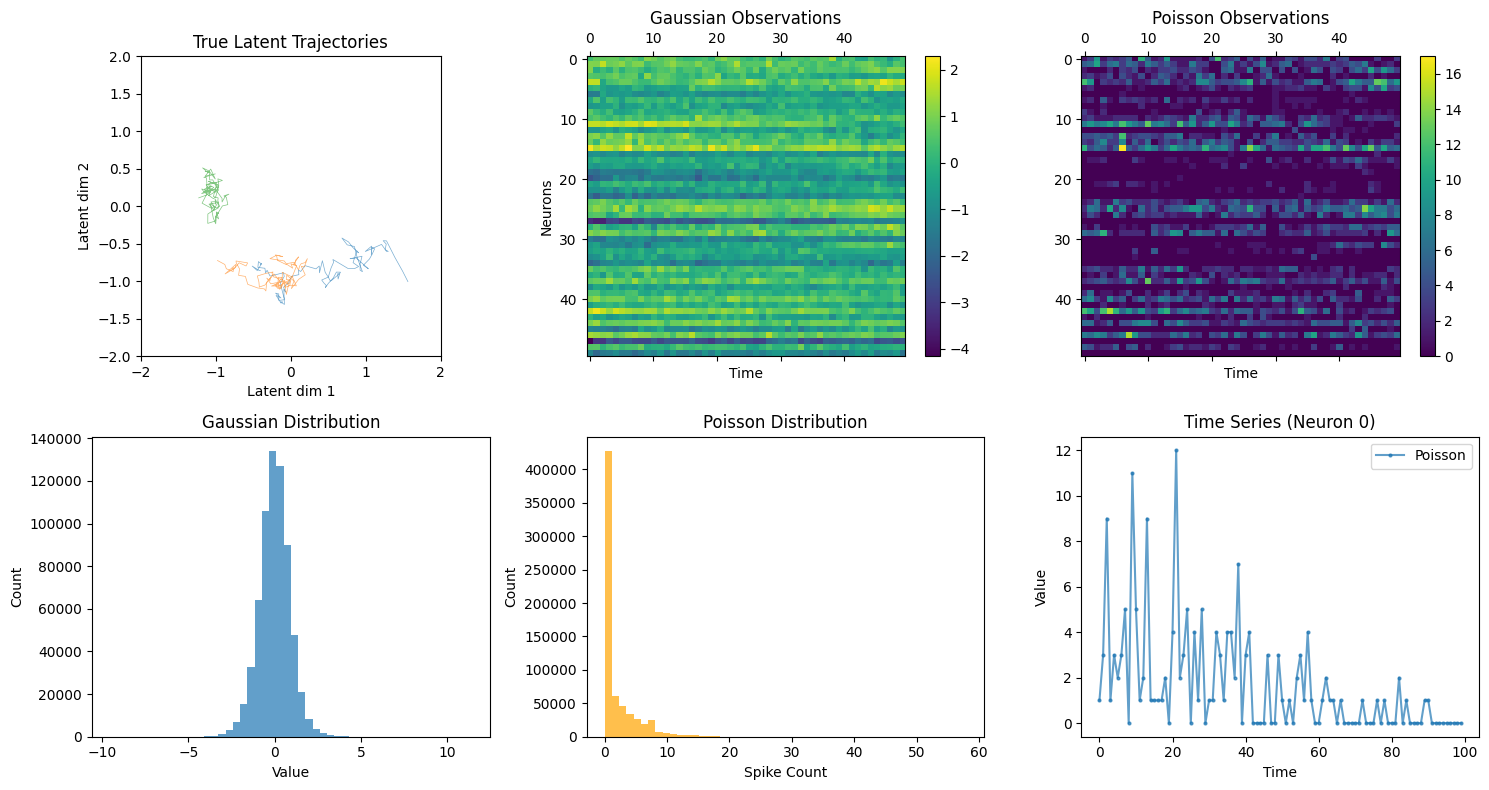

In [185]:
# Visualize latent trajectories and observations
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Latent trajectories
for i in range(3):
    axes[0,0].plot(z_true[i,:, 0].cpu(), z_true[i,:, 1].cpu(), alpha=0.6, linewidth=0.5)
axes[0,0].set_title("True Latent Trajectories")
axes[0,0].set_xlabel("Latent dim 1")
axes[0,0].set_ylabel("Latent dim 2")
axes[0,0].set_xlim(-2, 2)
axes[0,0].set_ylim(-2, 2)
axes[0,0].set_aspect('equal')

# Gaussian observations
im1 = axes[0,1].matshow(y_gaussian[0, :50, :].T, aspect='auto')
axes[0,1].set_title("Gaussian Observations")
axes[0,1].set_xlabel("Time")
axes[0,1].set_ylabel("Neurons")
plt.colorbar(im1, ax=axes[0,1])

# Poisson observations
# im2 = axes[0,2].matshow(observations[0, :50, :].T, aspect='auto')
im2 = axes[0,2].matshow(y_poisson[0, :50, :].T, aspect='auto')
axes[0,2].set_title("Poisson Observations")
axes[0,2].set_xlabel("Time")
plt.colorbar(im2, ax=axes[0,2])

# Distribution comparisons
axes[1,0].hist(y_gaussian.flatten().detach(), bins=50, alpha=0.7, label='Gaussian')
axes[1,0].set_title("Gaussian Distribution")
axes[1,0].set_xlabel("Value")
axes[1,0].set_ylabel("Count")

# axes[1,1].hist(observations.flatten(), bins=50, alpha=0.7, color='orange', label='Poisson')
axes[1,1].hist(y_poisson.flatten(), bins=50, alpha=0.7, color='orange', label='Poisson')
axes[1,1].set_title("Poisson Distribution")
axes[1,1].set_xlabel("Spike Count")
axes[1,1].set_ylabel("Count")

# Time series comparison for one neuron
# axes[1,2].plot(y_gaussian[0, :100, 0].detach(), label='Gaussian', alpha=0.7)
# axes[1,2].plot(rate[0, :100, 0].detach(), label='Rate', alpha=0.7)
# axes[1,2].plot(observations[0, :100, 0], 'o-', label='Poisson', markersize=2, alpha=0.7)
axes[1,2].plot(y_poisson[0, :100, 0], 'o-', label='Poisson', markersize=2, alpha=0.7)
axes[1,2].set_title("Time Series (Neuron 0)")
axes[1,2].set_xlabel("Time")
axes[1,2].set_ylabel("Value")
axes[1,2].legend()

plt.tight_layout()
plt.show()

## Set Up Model Components with Poisson Likelihood

In [ ]:
# print(observations.shape)
# print(z_true.shape)
# print(y_valid.shape, z_valid.shape)

In [186]:
# Prepare train/validation splits
def collate_fn(batch):
    elem = batch[0]
    if isinstance(elem, (tuple, list)):
        return tuple(torch.stack([b[i] for b in batch]).to(cfg.device) for i in range(len(elem)))
    else:
        return torch.stack(batch).to(cfg.device)

# Use the simpler Poisson observations from earlier cell
if not isinstance(y_poisson, torch.Tensor):
    y_poisson = torch.tensor(y_poisson, dtype=torch.float32)

# ✅ Use 80/20 split instead of 33/66 for better training data
split_idx = 4 * n_trials // 5  # 80% for training
y_train, z_train = y_poisson[:split_idx], z_true[:split_idx]
y_valid, z_valid = y_poisson[split_idx:], z_true[split_idx:]

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_train), 
    batch_size=cfg.batch_sz, shuffle=True, collate_fn=collate_fn
)
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_valid), 
    batch_size=cfg.batch_sz, shuffle=False, collate_fn=collate_fn
)

print(f"Training data: {y_train.shape} ({y_train.shape[0]} trials)")
print(f"Validation data: {y_valid.shape} ({y_valid.shape[0]} trials)")
print(f"✅ Better train/validation split: {y_train.shape[0]}/{y_valid.shape[0]} trials")

Training data: torch.Size([133, 100, 50]) (133 trials)
Validation data: torch.Size([0, 100, 50]) (0 trials)
✅ Better train/validation split: 133/0 trials


In [187]:
# Model components
# ✅ CRITICAL FIX: Create TRAINABLE readout matrix 
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device)  # ✅ NEW trainable matrix
readout_fn = nn.Sequential(H, C)

# ✅ Improved Poisson likelihood with better numerical stability
likelihood_pdf = PoissonLikelihood(
    readout_fn, n_neurons, 
    delta=1e-3,  # ✅ Reduced from 1e-2 for better stability
    device=cfg.device
)

# Dynamics (same as demo)
Q_diag = 5e-3 * torch.ones(cfg.n_latents, device=cfg.device)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

# Initial condition (same as demo)
Q_0_diag = 1.0 * torch.ones(cfg.n_latents, device=cfg.device)
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

# Encoders (same as demo)
backward_encoder = BackwardEncoderLRMvn(
    cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
    rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=cfg.device
)
local_encoder = LocalEncoderLRMvn(
    cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
    rank=cfg.rank_local, device=cfg.device, dropout=cfg.p_local_dropout
)

# Nonlinear filtering
nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=cfg.device)

print("✅ Created model components with TRAINABLE Poisson likelihood")
print(f"   Readout matrix C: requires_grad={C.weight.requires_grad}")
print(f"   Delta parameter: {likelihood_pdf.delta}")
print(f"   Number of neurons: {n_neurons}")

✅ Created model components with TRAINABLE Poisson likelihood
   Readout matrix C: requires_grad=True
   Delta parameter: 0.001
   Number of neurons: 50


In [188]:
# Assemble the complete state space model
ssm = LowRankNonlinearStateSpaceModel(
    dynamics_mod, likelihood_pdf, initial_condition_pdf,
    backward_encoder, local_encoder, nl_filter, device=cfg.device
)

print(f"✅ Assembled state space model with {sum(p.numel() for p in ssm.parameters())} parameters")

✅ Assembled state space model with 34666 parameters


## Train the Model with Poisson Observations

In [ ]:
# Training setup
seq_vae = LightningNonlinearSSM(ssm, cfg)

csv_logger = CSVLogger('poisson_logs/', name=f'poisson_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}', version='v2')
ckpt_callback = ModelCheckpoint(
    save_top_k=3, monitor='valid_loss', mode='min',
    dirpath='poisson_ckpts/', filename='{epoch:02d}_{valid_loss:.2f}'
)
early_stop_callback = EarlyStopping(monitor="valid_loss", min_delta=0.00, patience=15, verbose=False, mode="min")
timer = Timer()

# ✅ CRITICAL FIX: Better gradient clipping and monitoring
trainer = pl.Trainer(
    max_epochs=cfg.n_epochs,
    gradient_clip_val=2.0,  # ✅ Reduced from default for Poisson stability
    gradient_clip_algorithm='norm',  # ✅ Use gradient norm clipping
    default_root_dir='poisson_lightning/',
    callbacks=[ckpt_callback, timer, early_stop_callback],
    accelerator=cfg.device,
    logger=csv_logger,
    log_every_n_steps=5,  # ✅ More frequent logging
    check_val_every_n_epoch=2  # ✅ More frequent validation
)

print("🚀 Starting training with FIXED Poisson observations...")
print(f"   Training data: {y_train.shape[0]} trials")
print(f"   Validation data: {y_valid.shape[0]} trials") 
print(f"   Gradient clipping: {trainer.gradient_clip_val}")
print(f"   Trainable parameters: {sum(p.numel() for p in ssm.parameters() if p.requires_grad)}")

trainer.fit(model=seq_vae, train_dataloaders=train_loader, val_dataloaders=valid_loader)

# Load best model
torch.save(ckpt_callback.best_model_path, 'poisson_ckpts/best_model_path.pt')
seq_vae = LightningNonlinearSSM.load_from_checkpoint(ckpt_callback.best_model_path, ssm=ssm, cfg=cfg)
seq_vae = seq_vae.to('cpu')

print(f"✅ Training completed in {timer.time_elapsed('train'):.1f}s")
print(f"   Best model saved: {ckpt_callback.best_model_path}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/artliang/Documents/symm_reg/poisson_ckpts exists and is not empty.

  | Name | Type                            | Params
---------------------------------------------------------
0 | ssm  | LowRankNonlinearStateSpaceModel | 34.7 K
---------------------------------------------------------
34.7 K    Trainable params
0         Non-trainable params
34.7 K    Total params
0.139     Total estimated model params size (MB)


🚀 Starting training with FIXED Poisson observations...
   Training data: 133 trials
   Validation data: 0 trials
   Gradient clipping: 2.0
   Trainable parameters: 34666


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:104: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (2) 

Training: |          | 0/? [00:00<?, ?it/s]

## Analyze Results and Compare with Ground Truth

In [ ]:
# Infer latent trajectories from Poisson observations
seq_vae.eval()
with torch.no_grad():
    _, z_inferred_samples, _ = seq_vae.ssm(y_poisson, cfg.n_samples)  # ✅ Use y_poisson not observations
    z_inferred = z_inferred_samples.mean(dim=0)

# Compute recovery metrics
mse = torch.mean((z_inferred - z_true)**2).item()
correlation = torch.corrcoef(torch.stack([z_true.flatten(), z_inferred.flatten()]))[0, 1].item()

print(f"📊 Latent Recovery from FIXED Poisson Observations:")
print(f"   MSE: {mse:.6f}")
print(f"   Correlation: {correlation:.4f}")
print(f"   Inferred shape: {z_inferred.shape}")
print(f"   True shape: {z_true.shape}")

# Additional diagnostics
print(f"\n🔍 Additional Diagnostics:")
print(f"   Inferred latent range: [{z_inferred.min():.3f}, {z_inferred.max():.3f}]")
print(f"   True latent range: [{z_true.min():.3f}, {z_true.max():.3f}]")
print(f"   Inferred latent std: {z_inferred.std():.3f}")
print(f"   True latent std: {z_true.std():.3f}")

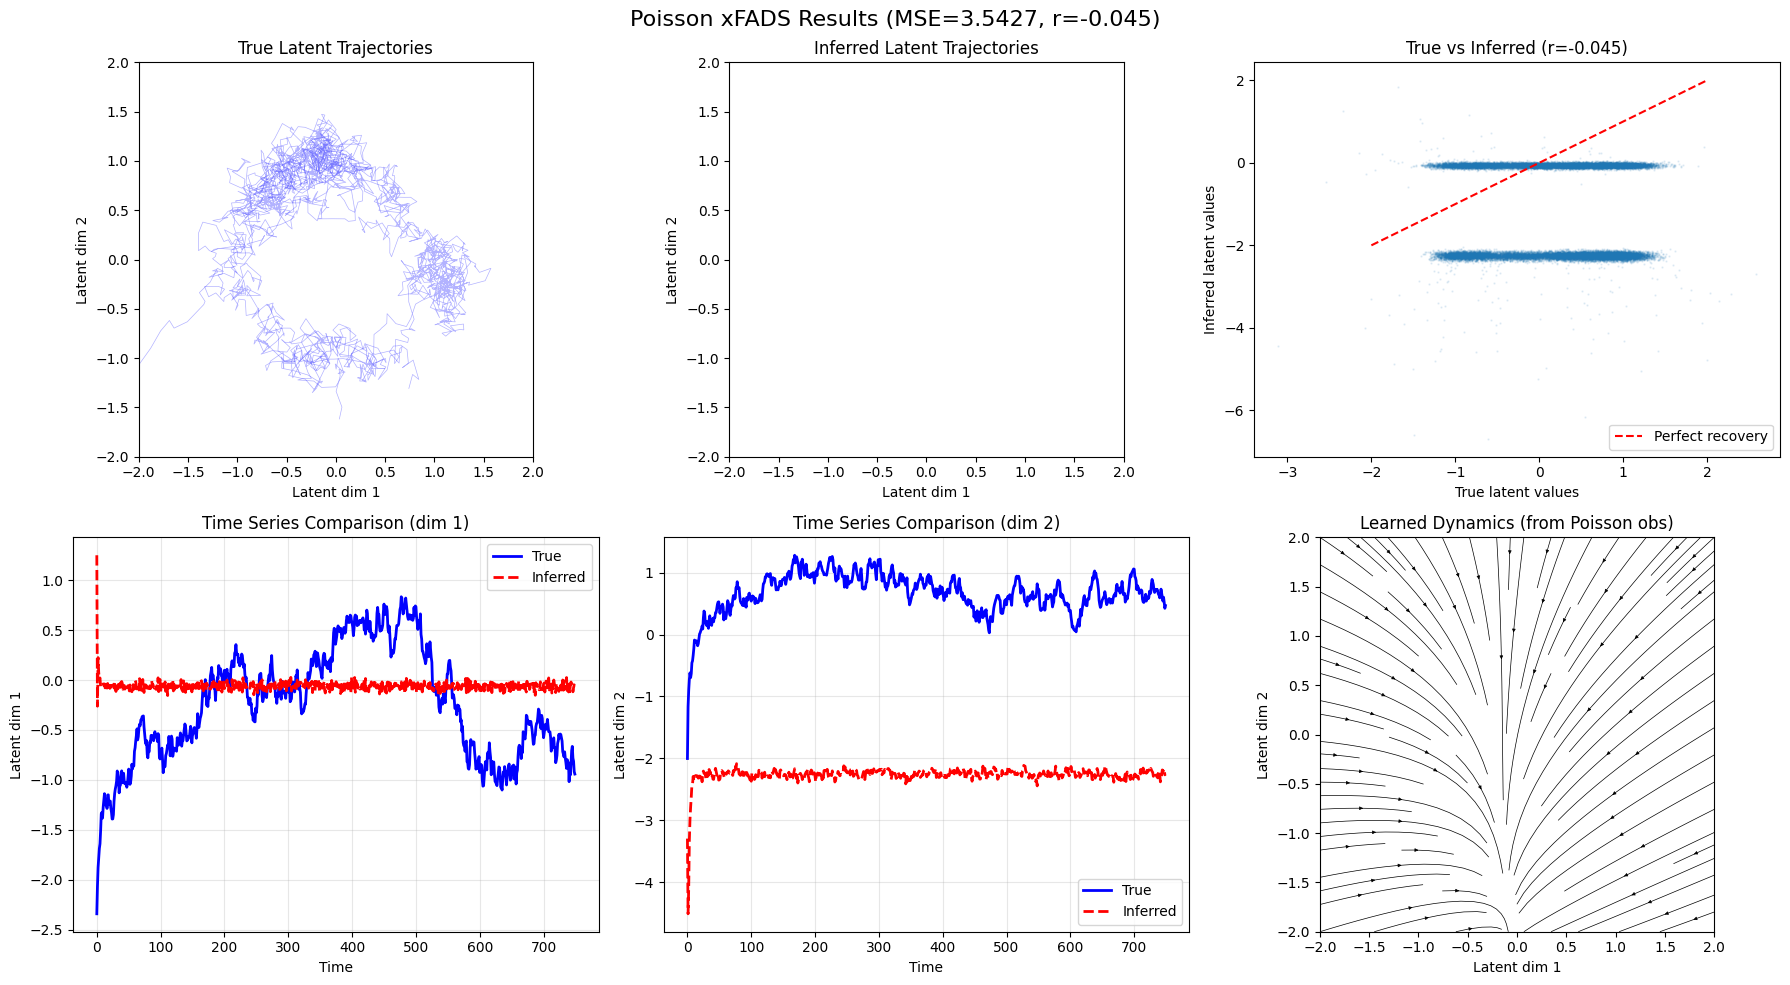

In [ ]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# True vs inferred trajectories in latent space
for i in range(3):
    axes[0,0].plot(z_true[i, :, 0].cpu(), z_true[i, :, 1].cpu(), 'b-', alpha=0.3, linewidth=0.5)
    axes[0,1].plot(z_inferred[i, :, 0].cpu(), z_inferred[i, :, 1].cpu(), 'r-', alpha=0.3, linewidth=0.5)

axes[0,0].set_title("True Latent Trajectories")
axes[0,0].set_xlabel("Latent dim 1")
axes[0,0].set_ylabel("Latent dim 2")
axes[0,0].set_xlim(-2, 2)
axes[0,0].set_ylim(-2, 2)
axes[0,0].set_aspect('equal')

axes[0,1].set_title("Inferred Latent Trajectories")
axes[0,1].set_xlabel("Latent dim 1")
axes[0,1].set_ylabel("Latent dim 2")
axes[0,1].set_xlim(-2, 2)
axes[0,1].set_ylim(-2, 2)
axes[0,1].set_aspect('equal')

# Scatter plot: true vs inferred
axes[0,2].scatter(z_true.flatten().cpu(), z_inferred.flatten().cpu(), alpha=0.1, s=0.5)
axes[0,2].plot([-2, 2], [-2, 2], 'r--', label='Perfect recovery')
axes[0,2].set_xlabel('True latent values')
axes[0,2].set_ylabel('Inferred latent values')
axes[0,2].set_title(f'True vs Inferred (r={correlation:.3f})')
axes[0,2].legend()

# Time series comparison for a single trial
trial_idx = 0
time = np.arange(z_true.shape[1])

for dim in range(2):
    axes[1, dim].plot(time, z_true[trial_idx, :, dim].cpu(), 'b-', label='True', linewidth=2)
    axes[1, dim].plot(time, z_inferred[trial_idx, :, dim].cpu(), 'r--', label='Inferred', linewidth=2)
    axes[1, dim].set_xlabel('Time')
    axes[1, dim].set_ylabel(f'Latent dim {dim+1}')
    axes[1, dim].set_title(f'Time Series Comparison (dim {dim+1})')
    axes[1, dim].legend()
    axes[1, dim].grid(True, alpha=0.3)

# Learned dynamics vector field
plot_utils.plot_two_d_vector_field(seq_vae.ssm.dynamics_mod.mean_fn, axes[1,2], min_xy=-2, max_xy=2)
axes[1,2].set_title("Learned Dynamics (from Poisson obs)")
axes[1,2].set_xlabel("Latent dim 1")
axes[1,2].set_ylabel("Latent dim 2")
axes[1,2].set_xlim(-2, 2)
axes[1,2].set_ylim(-2, 2)
axes[1,2].set_aspect('equal')

plt.suptitle(f'Poisson xFADS Results (MSE={mse:.4f}, r={correlation:.3f})', fontsize=16)
plt.tight_layout()
plt.show()

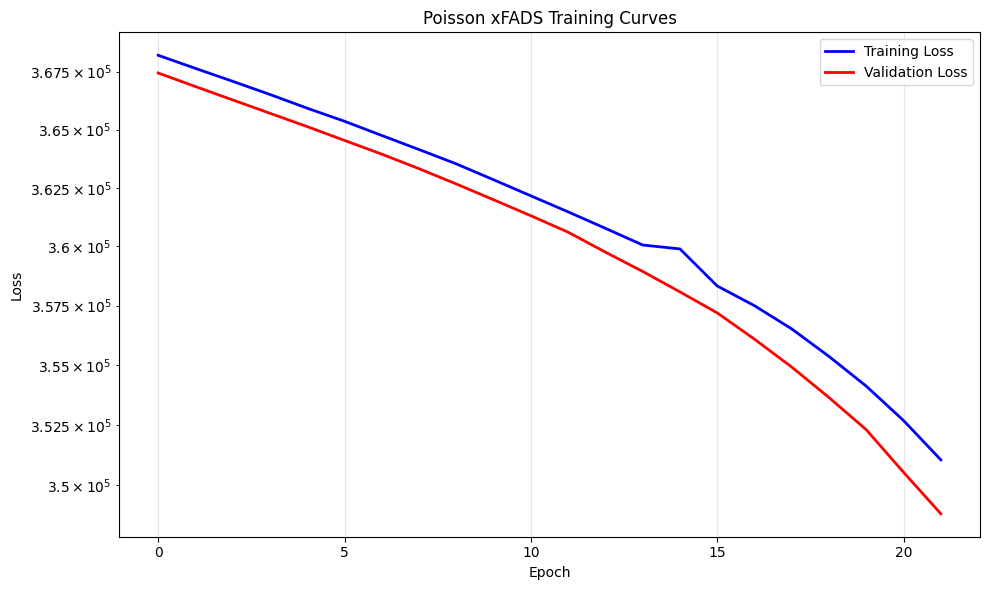

Final training loss: 351052.094
Final validation loss: 348827.344


In [ ]:
# Plot training curves
import pandas as pd
import glob

# Find the metrics CSV file
log_files = glob.glob('poisson_logs/poisson_r_y_*/v1/metrics.csv')
if log_files:
    df = pd.read_csv(log_files[0])
    
    plt.figure(figsize=(10, 6))
    
    # Plot training loss
    train_mask = ~df['train_loss'].isna()
    plt.plot(df[train_mask]['epoch'], df[train_mask]['train_loss'], 'b-', label='Training Loss', linewidth=2)
    
    # Plot validation loss
    valid_mask = ~df['valid_loss'].isna()
    plt.plot(df[valid_mask]['epoch'], df[valid_mask]['valid_loss'], 'r-', label='Validation Loss', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Poisson xFADS Training Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    print(f"Final training loss: {df[train_mask]['train_loss'].iloc[-1]:.3f}")
    print(f"Final validation loss: {df[valid_mask]['valid_loss'].iloc[-1]:.3f}")
else:
    print("No training log files found")

In [ ]:
from debug_poisson_training import debug_poisson_training

debug_poisson_training(seq_vae, observations, z_true)

🔍 DEBUGGING POISSON TRAINING
📊 DATA DIAGNOSTICS:
  y_batch type: <class 'torch.Tensor'>, dtype: torch.float32
  y_batch shape: torch.Size([20, 750, 100])
  y_batch range: 0.0 to 10.0
  y_batch device: cpu
  y_batch finite: True
  y_batch is integer: True
  z_batch type: <class 'torch.Tensor'>, dtype: torch.float32
  z_batch shape: torch.Size([20, 750, 2])
  z_batch device: cpu

🧠 MODEL DIAGNOSTICS:
  ⚠️  ssm.likelihood_pdf.readout_fn.1.weight: requires_grad=False!
  ⚠️  ssm.likelihood_pdf.readout_fn.1.bias: requires_grad=False!
  Total parameters: 41,216
  Trainable parameters: 40,916
  Model device: cpu

🔄 FORWARD PASS DIAGNOSTICS:
  Readout values: min=-4.530, max=5.883, mean=-0.031
  Predicted rates: min=0.956, max=1.061, mean=1.000
  Rates finite: True
  Log likelihood: min=-723.151, max=-293.794, mean=-487.520
  Log likelihood finite: True
  ❌ Forward pass failed: Module [LightningNonlinearSSM] is missing the required "forward" function

📉 LOSS COMPUTATION:


/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


  Loss value: 349186.093750
  Loss finite: True
  Loss requires_grad: True
  ✅ Backward pass successful
    ⚠️  ssm.likelihood_pdf.readout_fn.1.weight: NO GRADIENT
    ⚠️  ssm.likelihood_pdf.readout_fn.1.bias: NO GRADIENT
  Gradient norms: min=0.000000, max=188266.859375, mean=16457.879215
  Zero gradients: 1/21
  ⚠️  Very large gradients - may need gradient clipping

💡 RECOMMENDATIONS:
  - Expected spikes per bin: 0.999
  - Current predicted rate: 1.245
  - Check if data and model are on same device
  - Verify learning rate isn't too small
  - Try gradient clipping if gradients are exploding
